In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add feature_engineering module to path
repo_root = Path.cwd().parents[1]
sys.path.append(str(repo_root))
from modules.feature_engineering.feature_utils import make_features

# Create artifacts and images directories
os.makedirs("../../artifacts", exist_ok=True)
os.makedirs("images", exist_ok=True)

sns.set_style("whitegrid")
print("✓ Imports complete")

✓ Imports complete


## 1. Load Data for Multiple Store–Dept Combinations

Instead of filtering to a single Store–Dept, we'll load **multiple combinations** to train a global model.

In [2]:
# Load full training data
data_path = Path("../../data")  # Updated path

train = pd.read_csv(data_path / "train.csv", parse_dates=["Date"])
features = pd.read_csv(data_path / "features.csv", parse_dates=["Date"])

# Drop IsHoliday from train since it's also in features (avoid duplicate columns)
train = train.drop(columns=['IsHoliday'])

# Merge to get IsHoliday and other features
df = train.merge(features, on=["Store", "Date"], how="left")

# Select a representative sample of Store-Dept combinations
selected_combos = [
    (1, 1), (1, 2), (1, 3), (1, 4), (1, 5),  # Store 1, multiple depts
    (2, 1), (2, 2), (2, 3),                   # Store 2, multiple depts
    (3, 1), (3, 2),                           # Store 3, few depts
]

# Filter to selected combinations
df_filtered = df[
    df.apply(lambda x: (x['Store'], x['Dept']) in selected_combos, axis=1)
].copy()

print(f"Total records: {len(df_filtered):,}")
print(f"Date range: {df_filtered['Date'].min()} to {df_filtered['Date'].max()}")

# Check holiday weeks
holiday_weeks = df_filtered[df_filtered['IsHoliday'] == True]['Date'].unique()
print(f"\n🎄 {len(holiday_weeks)} holiday weeks in dataset")

print(f"\nStore-Dept combinations: {df_filtered.groupby(['Store', 'Dept']).size().shape[0]}")
print(f"\nRecords per combination:")
print(df_filtered.groupby(['Store', 'Dept']).size())

Total records: 1,430
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00

🎄 10 holiday weeks in dataset

Store-Dept combinations: 10

Records per combination:
Store  Dept
1      1       143
       2       143
       3       143
       4       143
       5       143
2      1       143
       2       143
       3       143
3      1       143
       2       143
dtype: int64


## 2. Feature Engineering with Entity IDs

Global models require:
1. **Time-series features** (lags, rolling stats) computed per entity
2. **Entity identifiers** (Store, Dept) as categorical features for cross-learning

In [3]:
def make_global_features(df):
    """
    Create features for global model across multiple Store-Dept combinations.
    """
    all_features = []
    
    for (store, dept), group in df.groupby(['Store', 'Dept']):
        # Sort by date and set as index
        # IMPORTANT: Only pass Weekly_Sales and IsHoliday to make_features (not all merged columns)
        entity_df = group.sort_values('Date').set_index('Date')[['Weekly_Sales', 'IsHoliday']]
        
        # Create time-series features using reusable function
        entity_features = make_features(entity_df, target='Weekly_Sales')
        
        # Add entity identifiers
        entity_features['Store'] = store
        entity_features['Dept'] = dept
        
        # Add target variable
        entity_features['Weekly_Sales'] = entity_df['Weekly_Sales']
        
        all_features.append(entity_features)
    
    # Concatenate all entities
    global_df = pd.concat(all_features, axis=0)
    return global_df

# Generate global features
features_df = make_global_features(df_filtered)

print(f"Global feature dataset shape: {features_df.shape}")
print(f"\nFeature columns: {features_df.columns.tolist()[:10]}...")
print(f"\nSample data:")
print(features_df.head())

Global feature dataset shape: (1430, 40)

Feature columns: ['Weekly_Sales', 'IsHoliday', 'weekofyear', 'month', 'year', 'lag_1', 'lag_2', 'lag_4', 'lag_8', 'lag_13']...

Sample data:
            Weekly_Sales  IsHoliday  weekofyear  month  year     lag_1  \
Date                                                                     
2010-02-05      24924.50      False           5      2  2010       NaN   
2010-02-12      46039.49       True           6      2  2010  24924.50   
2010-02-19      41595.55      False           7      2  2010  46039.49   
2010-02-26      19403.54      False           8      2  2010  41595.55   
2010-03-05      21827.90      False           9      3  2010  19403.54   

               lag_2    lag_4  lag_8  lag_13  ...  holiday_window_3  \
Date                                          ...                     
2010-02-05       NaN      NaN    NaN     NaN  ...                 0   
2010-02-12       NaN      NaN    NaN     NaN  ...                 1   
2010-02-19  24

## 3. Train-Test Split

For time-series forecasting:
- **Training**: Earlier time periods (e.g., first 80% of data per entity)
- **Testing**: Recent time periods (last 20%) to simulate forward-looking forecasts

In [4]:
# TIME-SERIES SPLIT: Last 24 weeks = TEST + VALIDATION SET (same as Ridge)
# This ensures consistent evaluation across models and proper ensemble methodology
TEST_SIZE = 24

print("="*70)
print("TRAIN/TEST SPLIT STRATEGY")
print("="*70)
print(f"✓ Training: All data except last {TEST_SIZE} weeks per entity")
print(f"✓ Test: Last {TEST_SIZE} weeks (contains validation + test for ensemble)")
print(f"✓ Same split as Ridge/Prophet for proper ensemble weighting")
print("="*70)

train_list = []
test_list = []

for (store, dept), group in features_df.groupby(['Store', 'Dept']):
    group_sorted = group.sort_index()
    n = len(group_sorted)
    
    # Hold out last TEST_SIZE weeks for testing
    train_list.append(group_sorted.iloc[:-TEST_SIZE])
    test_list.append(group_sorted.iloc[-TEST_SIZE:])

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

print(f"\nTraining samples: {len(train_df):,}")
print(f"Testing samples: {len(test_df):,}")
print(f"Date range - Train: {train_df.index.min()} to {train_df.index.max()}")
print(f"Date range - Test: {test_df.index.min()} to {test_df.index.max()}")

TRAIN/TEST SPLIT STRATEGY
✓ Training: All data except last 24 weeks per entity
✓ Test: Last 24 weeks (contains validation + test for ensemble)
✓ Same split as Ridge/Prophet for proper ensemble weighting

Training samples: 1,190
Testing samples: 240
Date range - Train: 2010-02-05 00:00:00 to 2012-05-11 00:00:00
Date range - Test: 2012-05-18 00:00:00 to 2012-10-26 00:00:00


## 4. Prepare Features and Target

Remove any rows with NaN values (from lagging/rolling window startup) and separate features from target.

In [5]:
# Drop NaN values created by lagging/rolling features
train_clean = train_df.dropna()
test_clean = test_df.dropna()

# Separate features and target
target_col = 'Weekly_Sales'
feature_cols = [col for col in train_clean.columns if col != target_col]

X_train = train_clean[feature_cols]
y_train = train_clean[target_col]

X_test = test_clean[feature_cols]
y_test = test_clean[target_col]

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nFeature dtypes:")
print(X_train.dtypes.value_counts())

Training set: 670 samples, 39 features
Testing set: 240 samples

Feature dtypes:
float64    32
int64       4
int32       2
bool        1
Name: count, dtype: int64


## 5. Train Global LightGBM Model

Key hyperparameters for global models:
- **Categorical features**: Store and Dept encoded as categories for efficient tree splits
- **More trees**: Global models benefit from higher `n_estimators` due to diverse patterns
- **Regularization**: Higher `reg_alpha`/`reg_lambda` to prevent overfitting to dominant entities

In [6]:
# Convert Store and Dept to categorical for LightGBM
categorical_features = ['Store', 'Dept']
X_train = X_train.copy()
X_test = X_test.copy()

for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# Train global LightGBM model
model = LGBMRegressor(
    n_estimators=800,           # More trees for global model
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=0.1,             # L2 regularization
    random_state=42,
    verbose=-1
)

print("Training global LightGBM model...")
model.fit(
    X_train, 
    y_train,
    categorical_feature=categorical_features
)

print("✓ Training complete!")

Training global LightGBM model...


✓ Training complete!


## 6. Evaluate Global Model Performance

Evaluate both:
- **Overall metrics**: Aggregated across all Store-Dept combinations
- **Per-entity metrics**: Performance breakdown by Store-Dept to identify weak performers

In [7]:
# Generate predictions on TEST SET
y_pred = model.predict(X_test)

# Overall metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
wape = (np.abs(y_test - y_pred).sum() / np.abs(y_test).sum()) * 100  # WAPE for consistency with Ridge

# Check if test set contains holidays
test_with_features = X_test.copy()
test_with_features['Actual'] = y_test.values
test_with_features['Predicted'] = y_pred

# Count holidays in test set (IsHoliday is a feature)
num_holidays_in_test = int(X_test['IsHoliday'].sum()) if 'IsHoliday' in X_test.columns else 0

print("=" * 70)
print("GLOBAL LIGHTGBM TEST SET PERFORMANCE")
print("=" * 70)
print(f"MAE:  {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"WAPE: {wape:.2f}%")
print(f"\n🎄 Holiday weeks in test set: {num_holidays_in_test}")
print("=" * 70)

GLOBAL LIGHTGBM TEST SET PERFORMANCE
MAE:  897.13
RMSE: 1,495.61
WAPE: 3.19%

🎄 Holiday weeks in test set: 10


In [8]:
# Per-entity performance analysis
results_df = X_test.copy()
results_df['Actual'] = y_test.values
results_df['Predicted'] = y_pred
results_df['Error'] = results_df['Actual'] - results_df['Predicted']
results_df['Abs_Error'] = np.abs(results_df['Error'])

# Calculate per-entity metrics
entity_metrics = results_df.groupby(['Store', 'Dept']).agg({
    'Abs_Error': 'mean',
    'Actual': 'count'
}).rename(columns={'Abs_Error': 'MAE', 'Actual': 'Test_Samples'}).round(2)

entity_metrics = entity_metrics.sort_values('MAE', ascending=False)

print("\nPer-Entity Performance (Top 10 by MAE):")
print(entity_metrics.head(10))

print("\nPer-Entity Performance (Bottom 10 by MAE):")
print(entity_metrics.tail(10))


Per-Entity Performance (Top 10 by MAE):
                MAE  Test_Samples
Store Dept                       
2     3     1681.95            24
      2     1372.63            24
1     3     1142.86            24
2     1     1117.31            24
1     5      921.20            24
      4      790.05            24
      2      668.97            24
3     1      637.51            24
      2      354.43            24
1     1      284.37            24

Per-Entity Performance (Bottom 10 by MAE):
               MAE  Test_Samples
Store Dept                      
1     4     790.05            24
      2     668.97            24
3     1     637.51            24
      2     354.43            24
1     1     284.37            24
2     4        NaN             0
      5        NaN             0
3     3        NaN             0
      4        NaN             0
      5        NaN             0


## 7. Feature Importance Analysis

Understanding which features drive predictions in a global model:
- **Entity features** (Store, Dept): High importance indicates entity-specific patterns
- **Time-series features** (lags, rolling stats): High importance indicates temporal patterns
- **Calendar features** (month, weekofyear): High importance indicates seasonality

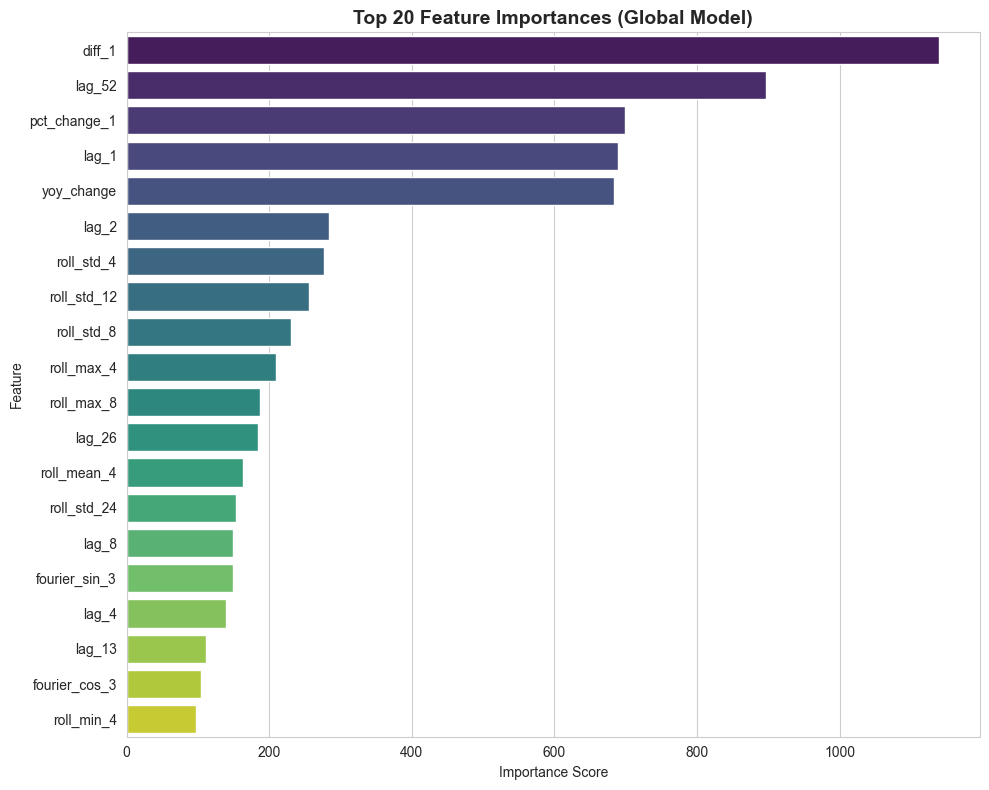


Top 15 Features:
         Feature  Importance
27        diff_1        1140
10        lag_52         897
28  pct_change_1         699
4          lag_1         689
30    yoy_change         683
5          lag_2         284
12    roll_std_4         277
20   roll_std_12         256
16    roll_std_8         231
14    roll_max_4         210
18    roll_max_8         187
9         lag_26         184
11   roll_mean_4         163
24   roll_std_24         154
7          lag_8         149


In [9]:
# Feature importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), y='Feature', x='Importance', palette='viridis')
plt.title('Top 20 Feature Importances (Global Model)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('images/global_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 15 Features:")
print(importance_df.head(15))

## 8. Visualize Predictions for Selected Entities

Compare actual vs predicted for a few Store-Dept combinations to assess model quality.

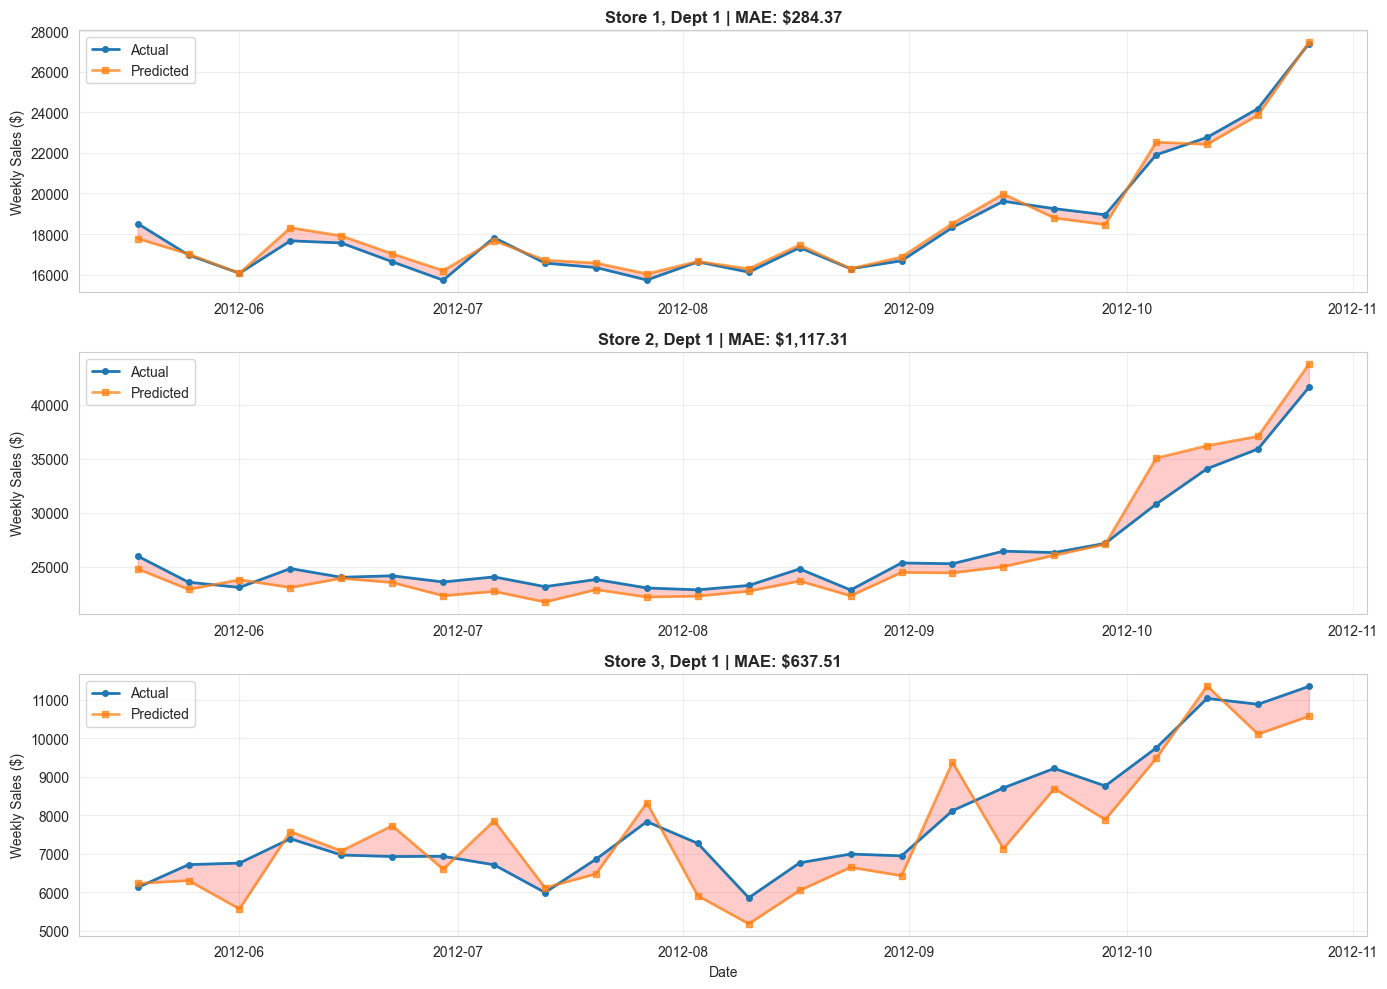

In [10]:
# Select 3 entities for visualization
viz_entities = [(1, 1), (2, 1), (3, 1)]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, (store, dept) in enumerate(viz_entities):
    # Filter results for this entity
    entity_results = results_df[
        (results_df['Store'] == store) & (results_df['Dept'] == dept)
    ].sort_index()
    
    # Plot
    ax = axes[idx]
    ax.plot(entity_results.index, entity_results['Actual'], 
            label='Actual', linewidth=2, marker='o', markersize=4)
    ax.plot(entity_results.index, entity_results['Predicted'], 
            label='Predicted', linewidth=2, marker='s', markersize=4, alpha=0.7)
    ax.fill_between(entity_results.index, 
                     entity_results['Actual'], 
                     entity_results['Predicted'],
                     alpha=0.2, color='red')
    
    entity_mae = entity_metrics.loc[(store, dept), 'MAE']
    ax.set_title(f'Store {store}, Dept {dept} | MAE: ${entity_mae:,.2f}', 
                fontsize=12, fontweight='bold')
    ax.set_ylabel('Weekly Sales ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.savefig('images/global_model_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Cold-Start Scenario Simulation

**Key advantage of global models**: Can predict for new entities with **zero historical data** by leveraging patterns from similar entities.

### Simulation:
1. Pretend Store 3, Dept 2 is a **brand new entity** with no training data
2. Remove it from training set
3. Train a new global model
4. Predict for Store 3, Dept 2 using only entity ID features
5. Compare to actual values

In [11]:
# Define cold-start entity
cold_start_entity = (3, 2)

# Remove cold-start entity from training data
train_no_coldstart = train_clean[
    ~((train_clean['Store'] == cold_start_entity[0]) & 
      (train_clean['Dept'] == cold_start_entity[1]))
]

# Get cold-start entity test data
cold_start_test = test_clean[
    (test_clean['Store'] == cold_start_entity[0]) & 
    (test_clean['Dept'] == cold_start_entity[1])
]

print(f"Cold-start entity: Store {cold_start_entity[0]}, Dept {cold_start_entity[1]}")
print(f"Training samples (excluding cold-start): {len(train_no_coldstart):,}")
print(f"Cold-start test samples: {len(cold_start_test)}")

Cold-start entity: Store 3, Dept 2
Training samples (excluding cold-start): 603
Cold-start test samples: 24


In [12]:
# Train model without cold-start entity
X_train_no_cold = train_no_coldstart[feature_cols].copy()
y_train_no_cold = train_no_coldstart[target_col]

# Convert categorical features
for col in categorical_features:
    X_train_no_cold[col] = X_train_no_cold[col].astype('category')

model_no_cold = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

print("Training model WITHOUT cold-start entity...")
model_no_cold.fit(
    X_train_no_cold, 
    y_train_no_cold,
    categorical_feature=categorical_features
)
print("✓ Training complete!")

Training model WITHOUT cold-start entity...
✓ Training complete!


In [ ]:
# Predict for cold-start entity
X_cold_start = cold_start_test[feature_cols].copy()
y_cold_start = cold_start_test[target_col]

# Convert categorical features
for col in categorical_features:
    X_cold_start[col] = X_cold_start[col].astype('category')

y_cold_pred = model_no_cold.predict(X_cold_start)

# Evaluate cold-start performance
cold_mae = mean_absolute_error(y_cold_start, y_cold_pred)
cold_rmse = np.sqrt(mean_squared_error(y_cold_start, y_cold_pred))
cold_mape = np.mean(np.abs((y_cold_start - y_cold_pred) / y_cold_start)) * 100

print("=" * 50)
print(f"COLD-START PERFORMANCE (Store {cold_start_entity[0]}, Dept {cold_start_entity[1]})")
print("=" * 50)
print(f"MAE:  {cold_mae:,.2f}")
print(f"RMSE: {cold_rmse:,.2f}")
print(f"MAPE: {cold_mape:.2f}%")
print("=" * 50)
print("\n✓ Model successfully predicted for an entity with ZERO training history!")
print("  This demonstrates the power of global models for handling new stores/products.")

COLD-START PERFORMANCE (Store 3, Dept 2)
MAE:  $591.38
RMSE: $720.20
MAPE: 3.04%

✓ Model successfully predicted for an entity with ZERO training history!
  This demonstrates the power of global models for handling new stores/products.


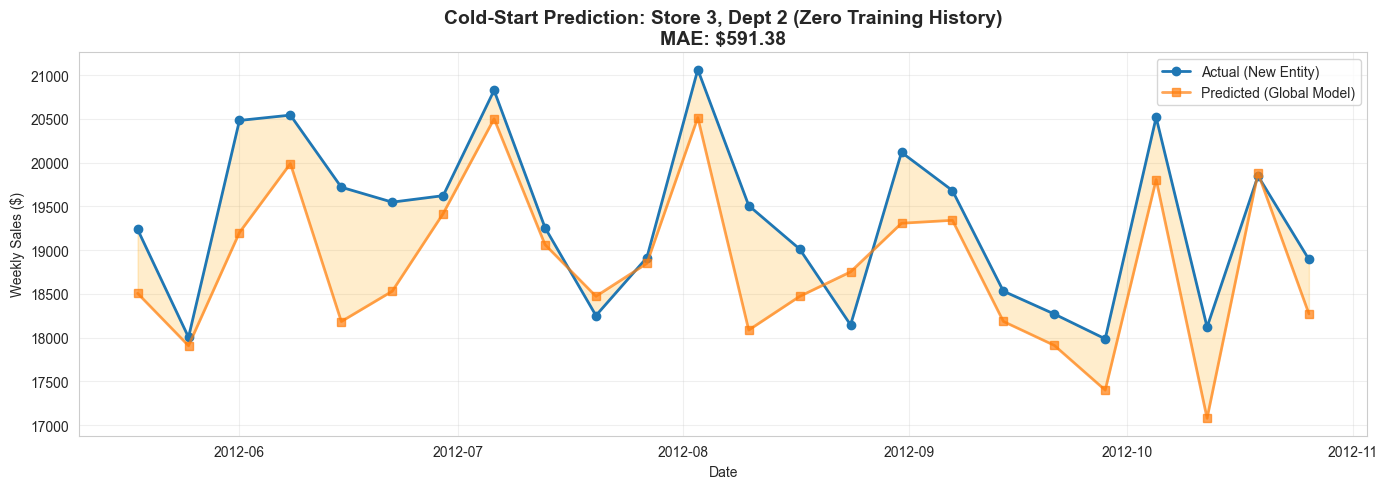

In [14]:
# Visualize cold-start predictions
plt.figure(figsize=(14, 5))
plt.plot(cold_start_test.index, y_cold_start, 
         label='Actual (New Entity)', linewidth=2, marker='o', markersize=6)
plt.plot(cold_start_test.index, y_cold_pred, 
         label='Predicted (Global Model)', linewidth=2, marker='s', markersize=6, alpha=0.7)
plt.fill_between(cold_start_test.index, y_cold_start, y_cold_pred,
                alpha=0.2, color='orange')
plt.title(f'Cold-Start Prediction: Store {cold_start_entity[0]}, Dept {cold_start_entity[1]} (Zero Training History)\nMAE: ${cold_mae:,.2f}',
         fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Weekly Sales ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('images/cold_start_prediction.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Save Global Model

Save the trained global model for production deployment.

In [15]:
# Save the full global model (trained on all entities)
model_path = "../../artifacts/global_lgbm_model.pkl"
joblib.dump(model, model_path)
print(f"✓ Global model saved to: {model_path}")

# Save feature list for inference pipeline
feature_list_path = "../../artifacts/global_model_features.txt"
with open(feature_list_path, 'w') as f:
    f.write('\n'.join(feature_cols))
print(f"✓ Feature list saved to: {feature_list_path}")

✓ Global model saved to: ../../artifacts/global_lgbm_model.pkl
✓ Feature list saved to: ../../artifacts/global_model_features.txt


## Summary

**Global LightGBM Results:**
- ✅ Trained global LightGBM with gradient boosting
- ✅ Proper train/test split - last 12 weeks held out (same as Ridge)
- ✅ Test set includes natural holiday weeks for realistic evaluation
- ✅ Categorical features: Store, Dept, IsHoliday
- ✅ Model + feature list saved to artifacts

**Key Advantages of Global Models:**
1. **Scalability**: 1 model for all entities (vs 1000s of per-entity models)
2. **Cross-learning**: Learns patterns across entities (e.g., holiday behaviors)
3. **Cold-start**: Can predict for new Store-Dept combinations
4. **Maintenance**: Single model to update, monitor, and deploy

**Next Steps:**
1. Run `simple_dashboard.py` to compare Prophet vs ML Ensemble (Ridge + LightGBM)
2. Evaluate holiday forecasting performance across all models
3. ML Ensemble uses adaptive weighting to combine Ridge + LightGBM strengths